In [1]:
import os
import fnmatch
from IPython import display
from natsort import natsorted, ns
import pickle
import shutil

import matplotlib.pyplot as plt
from matplotlib import image
import numpy as np

In [2]:
datasets_path = os.path.join(os.getcwd(), "../Local/datasets/data/")
shapenet_path = os.path.join(datasets_path, "ShapeNet/")
NMR_path = os.path.join(datasets_path, "NMR_Dataset/")

In [3]:
class_id = "02958343"

In [4]:
working_path = os.path.join(NMR_path, class_id)

In [5]:
def list_instance_ids(class_path):
    for f in os.listdir(class_path):
        if os.path.isdir(os.path.join(class_path, f)):
            yield f
def list_image_in_dir(path, ext="png"):
    for f in os.listdir(path):
        if os.path.isfile(os.path.join(path, f)) and not f.startswith('.') and fnmatch.fnmatch(f, '*.{}'.format(ext)):
            yield f

In [6]:
instance_ids = natsorted([f for f in list_instance_ids(working_path)], alg=ns.IGNORECASE)
print("found {} instances".format(len(instance_ids)))

found 7496 instances


In [7]:
print(os.listdir(os.path.join(working_path, instance_ids[0])))
print(os.listdir(os.path.join(working_path, instance_ids[0], "image")))
images = [f for f in list_image_in_dir(os.path.join(working_path, instance_ids[0], "image"))]
print("found {} images".format(len(images)))

['cameras.npz', 'pointcloud.npz', 'image', 'mask', 'visual_hull_depth']
['0000.png', '0001.png', '0002.png', '0003.png', '0004.png', '0005.png', '0006.png', '0007.png', '0008.png', '0009.png', '0010.png', '0011.png', '0012.png', '0013.png', '0014.png', '0015.png', '0016.png', '0017.png', '0018.png', '0019.png', '0020.png', '0021.png', '0022.png', '0023.png']
found 24 images


In [8]:
def show_images(class_path, instance_id):
    instance_path = os.path.join(class_path, instance_id, "image")
    image_names = natsorted([f for f in list_image_in_dir(instance_path)], alg=ns.IGNORECASE)
    image_paths = [os.path.join(os.path.join(instance_path, f)) for f in image_names]
    n_rows = int(np.sqrt(len(image_names)) + 1)

    for i in range(0, len(image_names)):
        img = image.imread(image_paths[i])
        plt.subplot(n_rows, n_rows, 1 + i)
        plt.axis("off")
        plt.imshow(img)

    plt.show()

1a1dcd236a1e6133860800e6696b8284


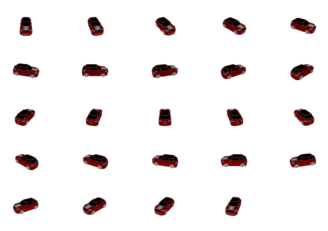

In [9]:
print(instance_ids[2])
show_images(working_path, instance_ids[2])

In [10]:
def camera_path(class_path, instance_id):
    return os.path.join(class_path, instance_id, 'cameras.npz')

In [11]:
with np.load(file=camera_path(working_path, instance_ids[2]), mmap_mode=None, allow_pickle=False, fix_imports=True) as f:
    print(natsorted(list(f.keys()), alg=ns.IGNORECASE))

['camera_mat_0', 'camera_mat_1', 'camera_mat_2', 'camera_mat_3', 'camera_mat_4', 'camera_mat_5', 'camera_mat_6', 'camera_mat_7', 'camera_mat_8', 'camera_mat_9', 'camera_mat_10', 'camera_mat_11', 'camera_mat_12', 'camera_mat_13', 'camera_mat_14', 'camera_mat_15', 'camera_mat_16', 'camera_mat_17', 'camera_mat_18', 'camera_mat_19', 'camera_mat_20', 'camera_mat_21', 'camera_mat_22', 'camera_mat_23', 'camera_mat_inv_0', 'camera_mat_inv_1', 'camera_mat_inv_2', 'camera_mat_inv_3', 'camera_mat_inv_4', 'camera_mat_inv_5', 'camera_mat_inv_6', 'camera_mat_inv_7', 'camera_mat_inv_8', 'camera_mat_inv_9', 'camera_mat_inv_10', 'camera_mat_inv_11', 'camera_mat_inv_12', 'camera_mat_inv_13', 'camera_mat_inv_14', 'camera_mat_inv_15', 'camera_mat_inv_16', 'camera_mat_inv_17', 'camera_mat_inv_18', 'camera_mat_inv_19', 'camera_mat_inv_20', 'camera_mat_inv_21', 'camera_mat_inv_22', 'camera_mat_inv_23', 'world_mat_0', 'world_mat_1', 'world_mat_2', 'world_mat_3', 'world_mat_4', 'world_mat_5', 'world_mat_6', 'w

In [12]:
def load_camera_matrices(class_path, instance_id, id):
    file_path = camera_path(class_path, instance_id)
    with np.load(file_path) as camera_dict:
        Rt = camera_dict['world_mat_inv_%d' % id].astype(np.float32)
        K = camera_dict['camera_mat_%d' % id].astype(np.float32)
    return Rt, K

In [13]:
load_camera_matrices(working_path, instance_ids[2], 2)

(array([[ 5.0000000e-01,  4.3301272e-01, -7.4999988e-01,  2.0490000e+00],
        [ 2.6262098e-08, -8.6602539e-01, -4.9999991e-01,  1.3660001e+00],
        [-8.6602545e-01,  2.5000000e-01, -4.3301257e-01,  1.1829907e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],
       dtype=float32),
 array([[3.732051, 0.      , 0.      , 0.      ],
        [0.      , 3.732051, 0.      , 0.      ],
        [0.      , 0.      , 1.      , 0.      ],
        [0.      , 0.      , 0.      , 1.      ]], dtype=float32))

In [14]:
def is_rotation_matrix(R):
    R_t = np.transpose(R)
    R_t_R = np.dot(R_t, R)
    I = np.identity(3, dtype = R.dtype)
    n = np.linalg.norm(I - R_t_R)
    return n < 1e-6

In [15]:
is_rotation_matrix(load_camera_matrices(working_path, instance_ids[2], 2)[0][0:3, 0:3])

True

In [22]:
def rotation_matrix_to_euler_angles(R) :
    if not is_rotation_matrix(R):
        raise ValueError('Input R is not a rotational matrix')
    sy = np.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
    singular = sy < 1e-6
    if not singular :
        x = np.arctan2(R[2,1] , R[2,2])
        y = np.arctan2(-R[2,0], sy)
        z = np.arctan2(R[1,0], R[0,0])
    else :
        x = np.arctan2(-R[1,2], R[1,1])
        y = np.arctan2(-R[2,0], sy)
        z = 0
    # RzRyRx = R
    return np.array([x, y, z])

In [34]:
rotation_matrix_to_euler_angles(load_camera_matrices(working_path, instance_ids[2], 2)[0][0:3, 0:3])

array([2.6179938e+00, 1.0471976e+00, 5.2524197e-08], dtype=float32)

p_cam = camera_mat @ world_mat @ scale_mat @ p_world
p_cam = H_world_mat @ p_world
R_world_mat = \[x^camera_world | y^camera_world | z^camera_world\] = R^camera_world
we want the rotation matrix from world to camera
R^world_camera = R_world_mat^-1

it appears that the inv world mat describes the transformation form world coord system
to the camera's coord system

we may assume that the z axis in the camera frame points at the origin of the world frame
and the model is placed at the origin of the world frame

we can verify this be computing the cross product of the third and last columns in Rt, which should be close to zero

In [39]:
def calculate_camera_z_world_origin_match(Rt):
    return np.linalg.norm(np.cross(Rt[:, 2], Rt[:, 3]))

def verify_camera_pose_assumption(Rt, threshold=1e-6):
    return calculate_camera_z_world_origin_match(Rt) < threshold

In [40]:
calculate_camera_z_world_origin_match(load_camera_matrices(working_path, instance_ids[2], 2)[0][0:3, :])

1.3328004e-07

In [41]:
verify_camera_pose_assumption(load_camera_matrices(working_path, instance_ids[2], 2)[0][0:3, :])

True

In [42]:
def verify_pose_in_dataset(class_path, threshold=1e-6):
    total_instances = 0
    failed_instances = 0
    total_poses = 0
    failed_poses = 0
    for instance_id in list_instance_ids(class_path):
        total_instances += 1
        file_path = camera_path(class_path, instance_id)
        # load cameras
        with np.load(file_path, mmap_mode='r') as camera_dict:
            instance_failed = False
            world_inv_mat_keys = natsorted([key for key in camera_dict.keys() if "world_mat_inv" in key], alg=ns.IGNORECASE)
            if len(world_inv_mat_keys) == 0:
                print("instance {} has no world inv matrices!".format(instance_id))
            total_poses += len(world_inv_mat_keys)
            for key in world_inv_mat_keys:
                Rt = camera_dict[key].astype(np.float32)
                dist = calculate_camera_z_world_origin_match(Rt[0:3, :])
                if dist > threshold:
                    instance_failed = True
                    failed_poses += 1
                    print("FAILED: instance {}, pose id {}, mismatch {}".format(instance_id, key, dist))
            failed_instances += 1 if instance_failed else 0
    return total_instances, failed_instances, total_poses, failed_poses

In [43]:
print(working_path)
total_instances, failed_instances, total_poses, failed_poses = verify_pose_in_dataset(working_path)
print("{}/{} instances failed, {}/{} poses failed".format(failed_instances, total_instances, failed_poses, total_poses))

/Volumes/Ed/Thesis/pi-GAN/../Local/datasets/data/NMR_Dataset/02958343
0/7496 instances failed, 0/179904 poses failed


it worked :)

now we calculate the yaw and pitch along the unit sphere (as in Pi-GAN paper)
since we can assume that the camera's z axis points at the center of the world origin,
and that the model is in a unit box centered at the world origin,
we can acquire the angles along the sphere from only the translation component t

we will dictate that the camera must be in the northern hemisphere
\t to that effect, we will discard violating captures from the dataset

we will use the axis notation in ShapeNetCore V2, that is
z axis points to the back
y axis points up
x axis follows RHL (to the right)

we define
alpha as the angle about the y axis in the right hand direction, with x-axis as 0,
and gamma as the angle from the z-x plane, that is
alpha = atan2(-z, x)
gamma = atan2(y, norm([x, z]))

In [45]:
# calculate the yaw and pitch along the sphere for a camera pose Rt
def calculate_yaw_pitch_on_sphere(Rt):
    t = Rt[:, 3]
    alpha = np.arctan2(-t[2], t[0])
    gamma = np.arctan2(t[1], np.linalg.norm([t[0], t[2]]))
    return alpha, gamma

In [46]:
calculate_yaw_pitch_on_sphere(load_camera_matrices(working_path, instance_ids[2], 0)[0][0:3,:])

(0.0, 0.5235988)

In [47]:
calculate_yaw_pitch_on_sphere(load_camera_matrices(working_path, instance_ids[2], 2)[0][0:3,:])

(-0.52359873, 0.5235988)

In [90]:
def aggregate_yaw_pitch_on_sphere_over_dataset(class_path):
    alpha_total = None
    gamma_total = None

    batch_size = 1000
    alpha_batch = np.empty((batch_size,))
    gamma_batch = np.empty((batch_size,))
    batch_ctr = 0

    for instance_id in list_instance_ids(class_path):
        file_path = camera_path(class_path, instance_id)
        # load cameras
        with np.load(file_path, mmap_mode='r') as camera_dict:
            for key in camera_dict.keys():
                if "world_mat_inv" in key:
                    Rt = camera_dict[key].astype(np.float32)
                    # verify northern hemisphere
                    if Rt[1, 3] < 0:
                        print("SKIPPED, instance {}, matrix {}, y {}".format(instance_id, key, Rt[1,3]))
                        continue
                    alpha, gamma = calculate_yaw_pitch_on_sphere(Rt[0:3, :])
                    # register to batch
                    alpha_batch[batch_ctr] = alpha
                    gamma_batch[batch_ctr] = gamma
                    # increment batch counter
                    batch_ctr += 1
                    # concat to total
                    if batch_ctr >= batch_size:
                        if alpha_total is None:
                            alpha_total = alpha_batch
                            gamma_total = gamma_batch
                        else:
                            alpha_total = np.concatenate((alpha_total, alpha_batch))
                            gamma_total = np.concatenate((gamma_total, gamma_batch))
                        batch_ctr = 0
                        alpha_batch = np.empty((batch_size,))
                        gamma_batch = np.empty((batch_size,))

    # add the last batch if not empty
    if batch_ctr != 0:
        alpha_total = np.concatenate((alpha_total, alpha_batch[0:batch_ctr]))
        gamma_total = np.concatenate((gamma_total, gamma_batch[0:batch_ctr]))

    # return aggregates
    return alpha_total, gamma_total

In [91]:
# compute
alpha_total, gamma_total = aggregate_yaw_pitch_on_sphere_over_dataset(working_path)

In [92]:
len(alpha_total)

179904

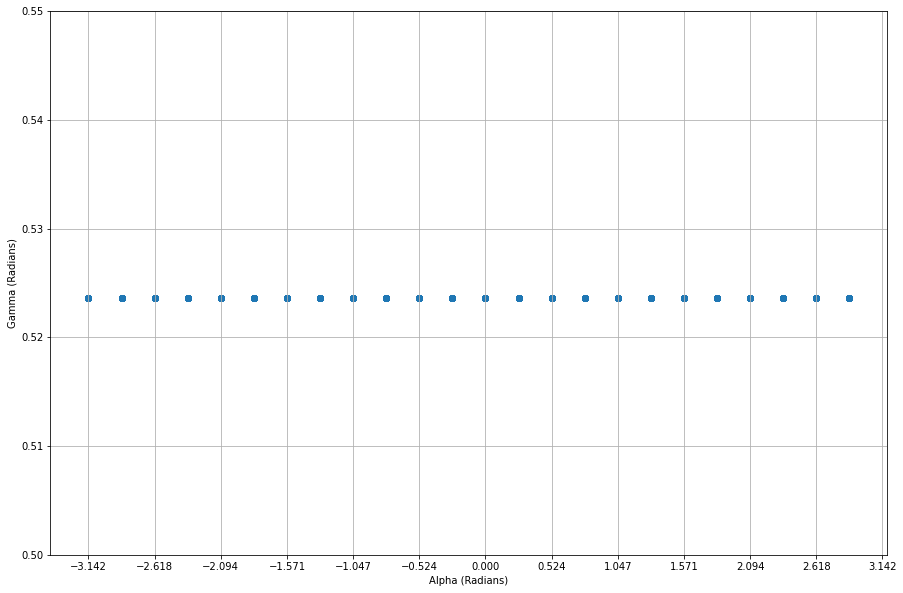

In [93]:
plt.figure(figsize=(15,10))
plt.scatter(alpha_total, gamma_total)
plt.xlabel("Alpha (Radians)")
plt.ylabel("Gamma (Radians)")
plt.xticks(np.linspace(-1*np.pi, 1*np.pi, 13))
plt.ylim([0.5, 0.55])
plt.grid()
plt.show()

In [94]:
np.min(alpha_total)

-3.141592502593994

In [95]:
np.max(alpha_total)

2.879793167114258

In [96]:
np.mean(gamma_total)

0.5235987827181816

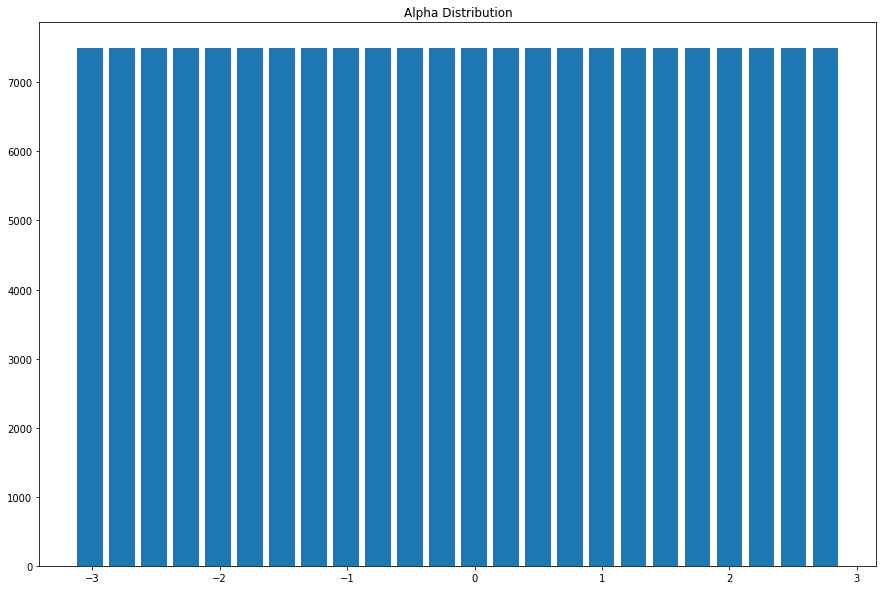

In [97]:
plt.figure(figsize=(15,10))
num_bins = 24
alpha_hist = plt.hist(alpha_total, bins=num_bins, rwidth=0.8)
plt.title("Alpha Distribution")
plt.show()

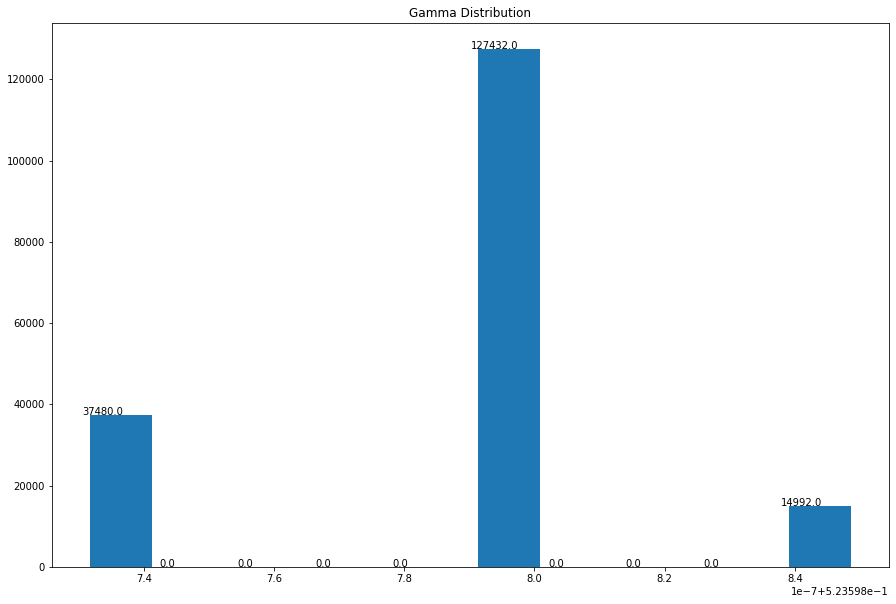

In [98]:
plt.figure(figsize=(15,10))
num_bins = 10
gamma_hist = plt.hist(gamma_total, bins=num_bins, rwidth=0.8)
plt.title("Gamma Distribution")
for i in range(num_bins):
    plt.text(gamma_hist[1][i],gamma_hist[0][i],str(gamma_hist[0][i]))
plt.show()

In [99]:
gamma_mu = np.mean(gamma_total)
gamma_std = np.std(gamma_total)
print("mu: {}, std: {}".format(gamma_mu, gamma_std))

mu: 0.5235987827181816, std: 3.131608221162978e-08


move data from individual folders to an aggregated folder
on this disk's file system, although each image is 2KB, it takes 128K on disk

In [100]:
128 * 179904

23027712

In [101]:
128 * 179904 / 1024

22488.0

In [103]:
128 * 179904 / 1024**2

21.9609375

so this should take 22GB on disk

In [24]:
def extract_images(class_path, target_dir):
    target_dir = os.path.abspath(target_dir)
    # verify that target dir exists
    assert(os.path.exists(target_dir) and os.path.isdir(target_dir))
    # iterate through class dir and copy images
    for instance_id in list_instance_ids(class_path):
        instance_path = os.path.join(class_path, instance_id, "image")
        # verify that instance dir exists
        assert(os.path.exists(instance_path) and os.path.isdir(instance_path))
        # copy all images
        for image_name in list_image_in_dir(instance_path):
            image_path = os.path.join(instance_path, image_name)
            dst_path = os.path.join(target_dir, "{}_{}".format(instance_id, image_name))

            if not os.path.exists(dst_path):
                shutil.copy2(image_path, dst_path)

            # display
            display.clear_output(wait=True)
            display.display("Instance {}, image {}".format(instance_id, image_name))

In [16]:
target_path = os.path.join(os.getcwd(), "../Local/datasets/data/", "ShapeNetCars")

In [17]:
target_path

'/Volumes/Ed/Thesis/pi-GAN/../Local/datasets/data/ShapeNetCars'

In [22]:
datasets_path

'/Volumes/Ed/Thesis/pi-GAN/../Local/datasets/data/'

In [19]:
os.path.exists(datasets_path)

True

In [20]:
os.path.exists(target_path)

True

In [23]:
os.makedirs(target_path)

FileExistsError: [Errno 17] File exists: '/Volumes/Ed/Thesis/pi-GAN/../Local/datasets/data/ShapeNetCars'

In [25]:
extract_images(working_path, target_path)

'Instance fffb1660a38af30ba4cf3601fb6b2442, image 0023.png'

In [24]:
# camera matrix has fx and fy
# we will assume fx and fy are the same
# we calculate both horizontal and diagonal FoVs. Since the images are squares, horizontal and diagonal FoVs are identical
# we know that the images are scaled to be [-1, 1] in both horizontal and vertical directions
def calculate_fov(camera_matrix):
    f_x = camera_matrix[0, 0]
    h_fov = 2 * np.arctan2(0.5 * 2, f_x)
    diag = np.linalg.norm([2, 2])
    diag_fov = 2 * np.arctan2(0.5 * diag, f_x)
    return h_fov, diag_fov

In [25]:
load_camera_matrices(working_path, instance_ids[2], 0)[1]

array([[3.732051, 0.      , 0.      , 0.      ],
       [0.      , 3.732051, 0.      , 0.      ],
       [0.      , 0.      , 1.      , 0.      ],
       [0.      , 0.      , 0.      , 1.      ]], dtype=float32)

In [26]:
calculate_fov(load_camera_matrices(working_path, instance_ids[2], 0)[1])

(0.5235987637921843, 0.7244362747751756)

In [27]:
np.degrees(calculate_fov(load_camera_matrices(working_path, instance_ids[2], 0)[1]))

array([29.99999932, 41.50714107])